## Objectif

L’objectif de ce notebook est d’évaluer la faisabilité d’une classification
automatique des produits à partir de leur description textuelle,
en utilisant des techniques d’embedding sémantique.

Les résultats seront comparés à ceux obtenus avec une approche TF-IDF
afin d’évaluer l’apport de ces représentations plus riches.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer


nltk.download('stopwords')
nltk.download('wordnet')

use_model = hub.load(
    "https://tfhub.dev/google/universal-sentence-encoder/4"
)

print("TF:", tf.__version__)
print("GPU visibles :", tf.config.list_physical_devices("GPU"))

2025-12-28 17:10:47.433282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-28 17:10:47.444860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766938247.456740    5249 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766938247.459778    5249 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-28 17:10:47.471816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TF: 2.18.0
GPU visibles : []


In [2]:
df = pd.read_csv("../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

# Sélection des colonnes utiles
df = df[["product_name", "description", "product_category_tree"]]

# Extraction de la catégorie principale
df["category"] = df["product_category_tree"].apply(
    lambda x: x.split(">>")[0].replace("[\"", "").strip()
)

df.head()


,product_name,description,product_category_tree,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing


In [3]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 2
    ]
    return " ".join(tokens)

df["text"] = (df["product_name"] + " " + df["description"]).apply(clean_text)
df[["product_name", "text"]].head()


,product_name,text
0,Elegance Polyester Multicolor Abstract Eyelet ...,elegance polyester multicolor abstract eyelet ...
1,Sathiyas Cotton Bath Towel,sathiyas cotton bath towel specification sathi...
2,Eurospa Cotton Terry Face Towel Set,eurospa cotton terry face towel set key featur...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton printed king size...
4,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king sized double b...


In [4]:
def embed_texts(texts, model, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model(batch)
        embeddings.append(emb.numpy())
    return np.vstack(embeddings)

texts = df["text"].astype(str).tolist()
X_use = embed_texts(texts, use_model, batch_size=32)

X_use.shape



2025-12-28 17:11:25.663743: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


(1050, 512)

In [5]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_use)


In [6]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_pca)


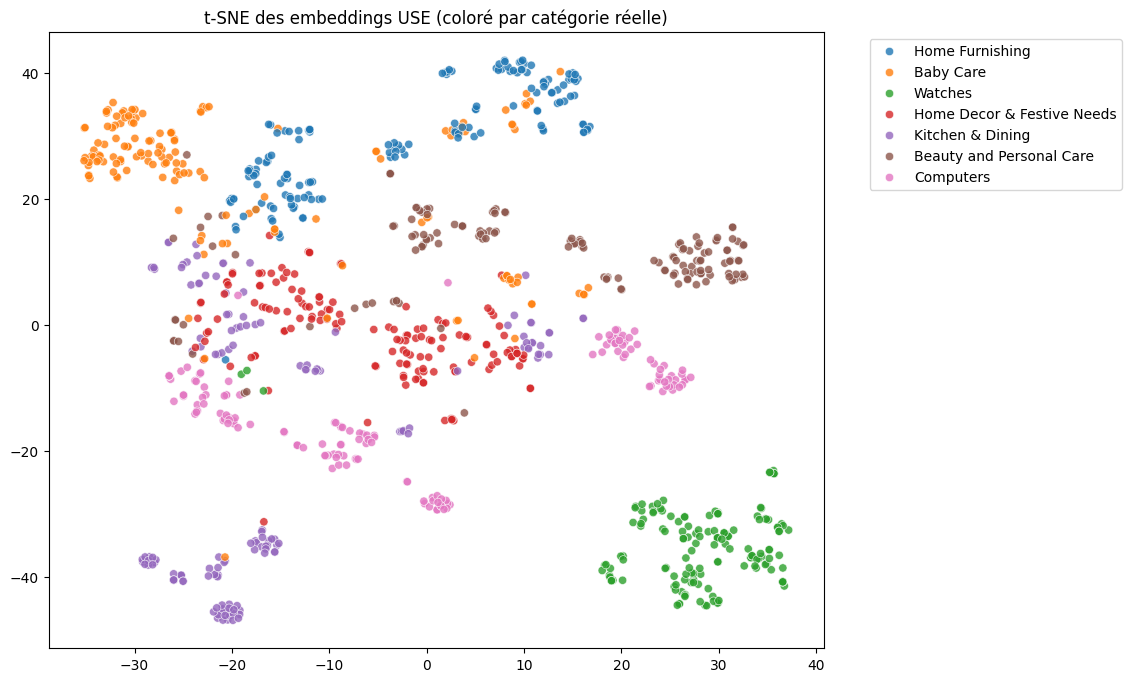

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=df["category"],
    palette="tab10",
    alpha=0.8
)
plt.title("t-SNE des embeddings USE (coloré par catégorie réelle)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [8]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

ari_use = adjusted_rand_score(df["category"], clusters)
ari_use


0.3649678158685255

In [9]:
#Word2Vec Embeddings
tokenized_texts = df["text"].apply(lambda x: x.split()).tolist()
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

In [10]:
#Phrase vectorization function

def sentence_vector(tokens, model, vector_size=300):
    vecs = []
    for tok in tokens:
        if tok in model.wv:
            vecs.append(model.wv[tok])
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)


In [11]:
X_w2v = np.vstack([
    sentence_vector(tokens, w2v_model, 300)
    for tokens in tokenized_texts
])
X_w2v.shape

(1050, 100)

In [12]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_w2v)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_pca)


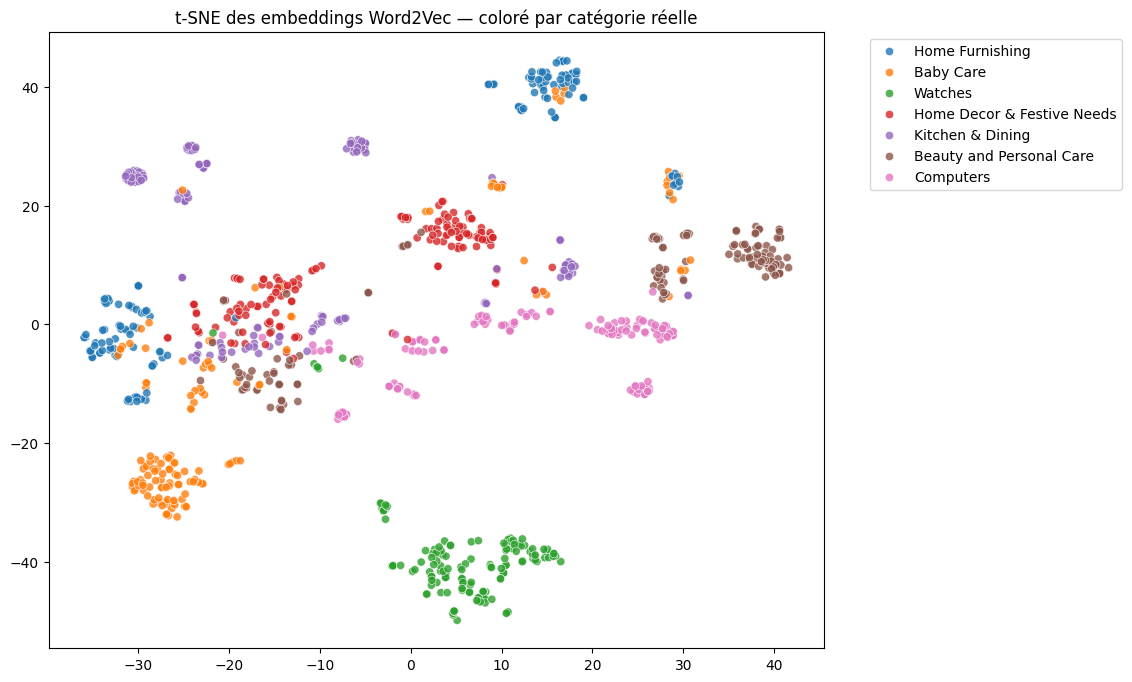

In [13]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=df["category"],
    palette="tab10",
    alpha=0.8
)
plt.title("t-SNE des embeddings Word2Vec — coloré par catégorie réelle")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


In [14]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

ari_w2v = adjusted_rand_score(df["category"], clusters)

print(f"ARI Word2Vec : {ari_w2v:.2f}")


ARI Word2Vec : 0.35


In [16]:
bert_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df["text"].astype(str).tolist()

X_bert = bert_model.encode(
    texts,
    batch_size=32,
    show_progress_bar=True
)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 686.64it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 33/33 [00:06<00:00,  5.48it/s]


In [17]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_bert)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_pca)


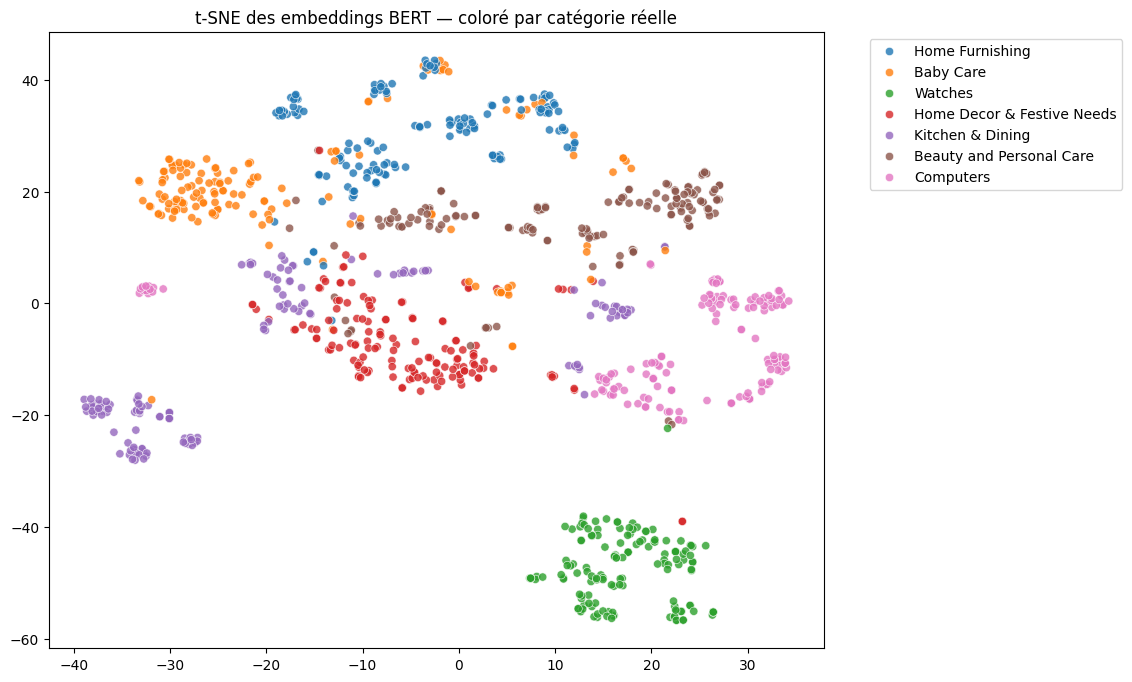

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=df["category"],
    palette="tab10",
    alpha=0.8
)
plt.title("t-SNE des embeddings BERT — coloré par catégorie réelle")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


In [19]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

ari_bert = adjusted_rand_score(df["category"], clusters)

print(f"ARI BERT : {ari_bert:.2f}")


ARI BERT : 0.56


In [21]:

print(f"ARI Word2Vec : {ari_w2v:.2f}")
print(f"ARI BERT : {ari_bert:.2f}")
print(f"ARI USE    : {ari_use:.2f}")

ARI Word2Vec : 0.35
ARI BERT : 0.56
ARI USE    : 0.36


Les embeddings issus du modèle Universal Sentence Encoder permettent
une représentation sémantique plus riche des descriptions textuelles.

Les visualisations t-SNE montrent une structuration comparable, voire améliorée,
par rapport à l’approche TF-IDF, confirmant la faisabilité d’une classification
automatique à partir de représentations textuelles avancées.
